# Simple CNN notebook

## Import Libraries

In [1]:
%matplotlib inline
import numpy as np
from utils.helper import read_data, blur, to_real, morphology
import cv2
import matplotlib.pyplot as plt
from tensorflow import keras
FOLDER = "data/data_big/"

## Load data

In [2]:
data_empty = read_data(FOLDER + "empty.csv")
data_1p = read_data(FOLDER + "1p.csv")
data_2p = read_data(FOLDER + "2p.csv")
data_3p = read_data(FOLDER + "3p.csv")
print("----------------Shapes----------------")
print("empty:", data_empty.shape)
print("1p:", data_1p.shape)
print("2p:", data_2p.shape)
print("3p:", data_3p.shape)

----------------Shapes----------------
empty: (480, 5, 3, 64, 64)
1p: (480, 5, 3, 64, 64)
2p: (480, 5, 3, 64, 64)
3p: (480, 5, 3, 64, 64)


In [133]:
data_1p_reshaped = data_1p.reshape(-1, 10,3,64,64)
data_2p_reshaped = data_2p.reshape(-1,10,3,64,64)
data_3p_reshaped = data_3p.reshape(-1,10,3,64,64)
data_empty_reshaped = data_empty.reshape(-1,10,3,64,64)
print(f"data_1p_reshaped: {data_1p_reshaped.shape}")
print(f"data_2p_reshaped: {data_2p_reshaped.shape}")
print(f"data_3p_reshaped: {data_3p_reshaped.shape}")
print(f"data_empty_reshaped: {data_empty_reshaped.shape}")

data_1p_reshaped: (240, 10, 3, 64, 64)
data_2p_reshaped: (240, 10, 3, 64, 64)
data_3p_reshaped: (240, 10, 3, 64, 64)
data_empty_reshaped: (240, 10, 3, 64, 64)


In [134]:
data_empty_abs = np.abs(data_empty_reshaped)
data_1p_abs = np.abs(data_1p_reshaped)
data_2p_abs = np.abs(data_2p_reshaped)
data_3p_abs = np.abs(data_3p_reshaped)
print(f"data_empty_abs: {data_empty_abs.shape}")
print(f"data_1p_abs: {data_1p_abs.shape}")
print(f"data_2p_abs: {data_2p_abs.shape}")
print(f"data_3p_abs: {data_3p_abs.shape}")

data_empty_abs: (240, 10, 3, 64, 64)
data_1p_abs: (240, 10, 3, 64, 64)
data_2p_abs: (240, 10, 3, 64, 64)
data_3p_abs: (240, 10, 3, 64, 64)


In [225]:

"""noise = np.mean(data_empty_abs[:,:,:,30:36,:], axis = 1) 
print(noise.shape)
noise = np.mean(noise[:,:,:,:], axis = 0) 
print(noise.shape)
noise = np.expand_dims(noise, axis = 0)
noise = np.expand_dims(noise, axis = 0)
print(noise.shape)
data_1p_abs[:,:,:,30:36,:] = data_1p_abs[:,:,:,30:36,:] - noise
data_2p_abs[:,:,:,30:36,:] = data_2p_abs[:,:,:,30:36,:] - noise
data_3p_abs[:,:,:,30:36,:] = data_3p_abs[:,:,:,30:36,:] - noise
print(f"data_1p_abs: {data_1p_abs.shape}")
print(f"data_2p_abs: {data_2p_abs.shape}")
print(f"data_3p_abs: {data_3p_abs.shape}")"""

(240, 3, 6, 64)
(3, 6, 64)
(1, 1, 3, 6, 64)
data_1p_abs: (240, 10, 3, 64, 64)
data_2p_abs: (240, 10, 3, 64, 64)
data_3p_abs: (240, 10, 3, 64, 64)


In [292]:



def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))*255

def calculate_saliency_map_3(frames, to_morph = True):
    """ n_frames, n_radars, 64, 64"""
    """new_frames = []
    for frame in frames:
        mean = np.mean(frame)
        frame_new = np.where(frame > mean, frame, 0)
        new_frames.append(frame_new)
    new_frames = np.array(new_frames)
    frames = new_frames"""
    frames[:,:,31:34,:] = 0
    # differences = np.abs(np.diff(frames, axis=0))
    #print(differences.shape)
    multiplications = np.zeros((frames.shape[0]-1, frames.shape[1], 64, 64))
    for i in range(frames.shape[0] - 1):
        for j in range(frames.shape[1]):
            mult = np.multiply(frames[i,j,:,:], frames[i+1,j,:,:])
            multiplications[i,j,:,:] = mult

    if to_morph:
        morphology = np.zeros(multiplications.shape)
        for i in range(multiplications.shape[0]):
            for j in range(multiplications.shape[1]):
                morph = cv2.morphologyEx(multiplications[i,j,:,:], cv2.MORPH_OPEN, np.ones((2, 2)))
                morphology[i,j,:,:] = morph
        saliency_map = np.expand_dims(np.sum(morphology, axis=0), axis=0)
    else:
        saliency_map = np.expand_dims(np.sum(multiplications, axis=0), axis=0)

    return normalize_data(saliency_map).squeeze()

def calculate_saliency_map_1(frames, to_morph = True):
    new_frames = []
    for frame in frames:
        mean = np.mean(frame)
        frame_new = np.where(frame > mean, frame, 0)
        new_frames.append(frame_new)
    new_frames = np.array(new_frames)
    frames = new_frames
    frames[:,31:34,:] = 0
    multiplications = []
    for i in range(frames.shape[0] - 1):
        multiplications.append(np.multiply(frames[i], frames[i + 1]))

    multiplications = np.array(multiplications)
    if to_morph:
        morph = np.array(
        [cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((5, 5))) for img in multiplications]
        )
        saliency_map = np.expand_dims(np.sum(morph, axis=0), axis=0)
    else:
        saliency_map = np.expand_dims(np.sum(multiplications, axis=0), axis=0)

    return normalize_data(saliency_map).squeeze()


def derivative(frames):
    frames[:,31:34,:] = 0
    img = np.sum(frames, axis = 0).squeeze()
    sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=3)
    sobelx = cv2.Sobel(sobelx,cv2.CV_64F,1,0,ksize=5)
    sobely = 1 - normalize_data(sobelx)
    return sobely

def subtract_noise(data, indices, noise):
    data[indices] 
    pass

def easy_preprocessing(frames):
    frames[:,31:34,:] = 0
    img = np.sum(frames, axis = 0).squeeze()
    return normalize_data(img)

In [304]:
data_empty_diffs = np.array([easy_preprocessing(sample) for sample in data_empty_abs])
data_1p_diffs = np.array([easy_preprocessing(sample)  for sample in data_1p_abs])
data_2p_diffs = np.array([easy_preprocessing(sample)  for sample in data_2p_abs])
data_3p_diffs = np.array([easy_preprocessing(sample)  for sample in data_3p_abs])

print(f"data_empty_diffs: {data_empty_diffs.shape}")
print(f"data_1p_diffs: {data_1p_diffs.shape}")
print(f"data_2p_diffs: {data_2p_diffs.shape}")
print(f"data_3p_diffs: {data_3p_diffs.shape}")

data_empty_diffs: (240, 3, 64, 64)
data_1p_diffs: (240, 3, 64, 64)
data_2p_diffs: (240, 3, 64, 64)
data_3p_diffs: (240, 3, 64, 64)


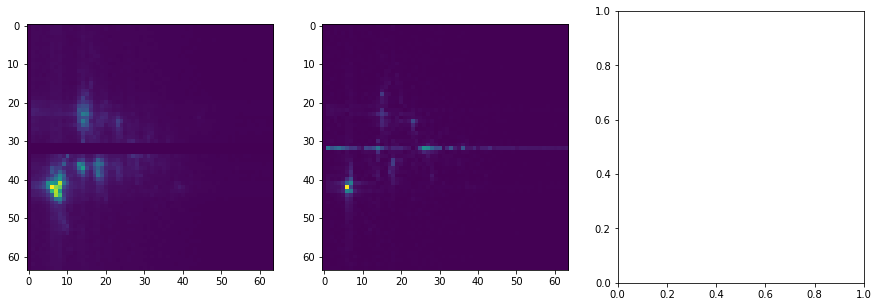

In [294]:
##### plot random sample
random_sample = np.random.randint(0, data_empty_diffs.shape[0])
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plot_sample = data_3p_diffs.copy()
ax[0].imshow(plot_sample[random_sample,0, :, :])
ax[1].imshow(plot_sample[random_sample, 1,:, :])
ax[2].imshow(plot_sample[random_sample, 2, :, :])

In [295]:
"""data_0 = np.moveaxis(data_empty_diffs, 1,3)
data_1 = np.moveaxis(data_1p_diffs, 1,3)
data_2 = np.moveaxis(data_2p_diffs, 1,3)
data_3 = np.moveaxis(data_3p_diffs, 1,3)
print(data_0.shape)
print(data_1.shape)
print(data_2.shape)
print(data_3.shape)"""
data_0 = data_empty_diffs
data_1 = data_1p_diffs
data_2 = data_2p_diffs
data_3 = data_3p_diffs
print(data_0.shape)
print(data_1.shape)
print(data_2.shape)
print(data_3.shape)

(240, 64, 64)
(240, 64, 64)
(240, 64, 64)
(240, 64, 64)


In [296]:
data_tot = np.concatenate((data_0, data_1, data_2, data_3), axis=0)
data_tot.shape

(960, 64, 64)

### Create Labels

In [297]:
labels_empty = np.zeros(data_0.shape[0])
labels_1p = np.ones(data_1.shape[0])
labels_2p = np.ones(data_2.shape[0]) * 2
labels_3p = np.ones(data_3.shape[0]) * 3
labels = np.concatenate((labels_empty, labels_1p, labels_2p, labels_3p), axis=0)
print("Labels shape:", labels.shape)

Labels shape: (960,)


In [298]:
train_labels_one_hot = np.eye(4)[labels.astype(int)]
print("Labels abels one hot shape:", train_labels_one_hot.shape)

Labels abels one hot shape: (960, 4)


In [299]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(data_tot, train_labels_one_hot, test_size=0.1, stratify=labels)
print(f"Shape train_X: {train_X.shape}")
print(f"Shape test_X: {test_X.shape}")
print(f"Shape train_y: {train_y.shape}")
print(f"Shape test_y: {test_y.shape}")

Shape train_X: (864, 64, 64)
Shape test_X: (96, 64, 64)
Shape train_y: (864, 4)
Shape test_y: (96, 4)


In [300]:
models = keras.models
layers = keras.layers

model = models.Sequential(
    [
        layers.Conv2D(4,
                      input_shape = (64,64, 1),
                      kernel_size = 5,
                      padding = "same",
                      activation = "relu"),
        layers.MaxPooling2D(2,
                            strides = None,
                            padding = "valid"),
        layers.Conv2D(4,
                    #   input_shape = (32,32, 1),
                      kernel_size = 3,
                      padding = "same",
                      activation = "relu"),
        layers.MaxPooling2D(2,
                    strides = None,
                    padding = "valid"),
        layers.Conv2D(4,
                    #   input_shape = (32,32, 1),
                      kernel_size = 3,
                      padding = "same",
                      activation = "relu"),
        layers.MaxPooling2D(2,
                    strides = None,
                    padding = "valid"),
        layers.Conv2D(2,
                    #   input_shape = (32,32, 1),
                      kernel_size = 3,
                      padding = "same",
                      activation = "relu"),
        layers.MaxPooling2D(2,
                    strides = None,
                    padding = "valid"),
        layers.Flatten(),
        layers.Dense(4),
        layers.Activation("softmax")
    ]
)
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_79 (Conv2D)          (None, 64, 64, 4)         104       
                                                                 
 max_pooling2d_79 (MaxPoolin  (None, 32, 32, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_80 (Conv2D)          (None, 32, 32, 4)         148       
                                                                 
 max_pooling2d_80 (MaxPoolin  (None, 16, 16, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (None, 16, 16, 4)         148       
                                                                 
 max_pooling2d_81 (MaxPoolin  (None, 8, 8, 4)        

In [301]:
model.compile(
    loss = "categorical_crossentropy",
    optimizer = keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

model.fit(
    train_X, train_y,
    epochs  = 1000,
    verbose = 1,
    validation_split = 0.1,
    shuffle= True,
    callbacks=keras.callbacks.EarlyStopping(patience = 10)
)

model.save('models/CNN')

Epoch 1/1000
25/25 [==============================] - 1s 32ms/step - loss: 5.7691 - accuracy: 0.1763 - val_loss: 2.1533 - val_accuracy: 0.1034
Epoch 2/1000
25/25 [==============================] - 1s 28ms/step - loss: 1.7400 - accuracy: 0.1583 - val_loss: 1.4322 - val_accuracy: 0.2759
Epoch 3/1000
25/25 [==============================] - 1s 30ms/step - loss: 1.3912 - accuracy: 0.3076 - val_loss: 1.2716 - val_accuracy: 0.4138
Epoch 4/1000
25/25 [==============================] - 1s 28ms/step - loss: 1.2726 - accuracy: 0.3758 - val_loss: 1.1580 - val_accuracy: 0.4483
Epoch 5/1000
25/25 [==============================] - 1s 26ms/step - loss: 1.1760 - accuracy: 0.4479 - val_loss: 1.0434 - val_accuracy: 0.4943
Epoch 6/1000
25/25 [==============================] - 1s 26ms/step - loss: 1.0848 - accuracy: 0.5032 - val_loss: 0.9558 - val_accuracy: 0.5632
Epoch 7/1000
25/25 [==============================] - 1s 27ms/step - loss: 1.0048 - accuracy: 0.5714 - val_loss: 0.8947 - val_accuracy: 0.6322

INFO:tensorflow:Assets written to: models/CNN\assets


INFO:tensorflow:Assets written to: models/CNN\assets


In [302]:
loss, aacuracy = model.evaluate(test_X, test_y)
print(f"Loss: {loss}")
print(f"Accuracy: {aacuracy}")

3/3 [==============================] - 0s 10ms/step - loss: 0.7026 - accuracy: 0.6875
Loss: 0.702586829662323
Accuracy: 0.6875


In [303]:
from sklearn.metrics import confusion_matrix
predicted = model.predict(test_X)
predicted_label = np.argmax(predicted, axis=1)
true_label = np.argmax(test_y, axis=1)
confusion_matrix(true_label, predicted_label)

3/3 [==============================] - 0s 11ms/step


array([[24,  0,  0,  0],
       [ 0, 13,  9,  2],
       [ 0,  2, 12, 10],
       [ 0,  2,  5, 17]], dtype=int64)